In [1]:
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# torch.multiprocessing.set_start_method('spawn')
# from act.policy import ACTPolicy
import gym_lite6.env, gym_lite6.scripted_policy, gym_lite6.pickup_task
%env MUJOCO_GL=egl # Had to export this before starting jupyter server
import mujoco

env: MUJOCO_GL=egl # Had to export this before starting jupyter server


In [2]:
gym_lite6.__path__

['/media/ssd/eugene/robotic_manipulation/gym_lite6/gym_lite6']

In [3]:
scene_path = gym_lite6.__path__[0] + "/../models/cube_pickup.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


""

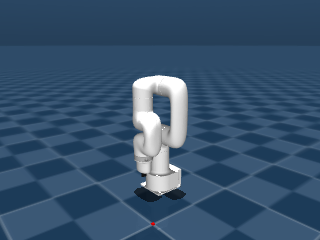

In [4]:

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())


In [11]:
DURATION = 4          # seconds
FRAMERATE = 60        # Hz
frames = []
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
mujoco.mj_resetData(model, data)
qpos = x0
data.qpos[:6] = qpos

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)

  data.ctrl[:6] = qpos
  # print(data.qpos)

  # data.qpos = 0.001
  if data.time < DURATION / 2:
    data.ctrl[6] = 30
  else:
    data.ctrl[6] = -30

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  # print(data.qfrc_actuator, data.qfrc_applied)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera)
    frames.append(renderer.render())
  
  qpos[0] -= 0.001

media.show_video(frames, loop=False)

""

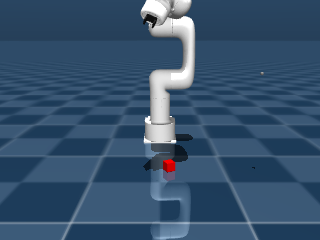

In [10]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
reload(gym_lite6.pickup_task)

task = gym_lite6.pickup_task.GraspTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
    visualization_width=320,
    visualization_height=240
)
observation, info = env.reset()
media.show_image(env.unwrapped.render(camera="side_cam"))


## Run a scripted rollout

In [12]:
# Run a scripted rollout

# policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
policy = gym_lite6.scripted_policy.GraspPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)

# Reset the policy and environmens to prepare for rollout
policy.reset()
observation, info = env.reset(seed=69)

frames = []
# Render frame of the initial state
frames.append(env.render())

step = 0
done = False

ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

while not done and len(frames) < 500:
  action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
  observation, reward, terminated, truncated, info = env.step(action)

  ep_dict["action.qpos"].append(action["qpos"])
  ep_dict["action.gripper"].append(action["gripper"])
  ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
  ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
  ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
  ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
  ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
  ep_dict["reward"].append(reward)
  ep_dict["timestamp"].append(env.unwrapped.data.time)
  ep_dict["frame_index"].append(step)

  if (policy.done):
      terminated = True
  print(f"{step=} {reward=} {terminated=}")

  # The rollout is considered done when the success state is reach (i.e. terminated is True),
  # or the maximum number of iterations is reached (i.e. truncated is True)
  done = terminated | truncated | done
  step += 1

if terminated:
  print("Success!")
else:
  print(f"Failure! Reached {policy.stage}")

media.show_video(ep_dict["observation.pixels.side"], fps=env.metadata["render_fps"])
media.show_video(ep_dict["observation.pixels.gripper"], fps=env.metadata["render_fps"])


{0: {'start_time': 0.0, 'end_time': 4.720234503197628, 'T_start': array([[ 0.61949266, -0.50540394,  0.60066273,  0.20268765],
       [ 0.30447578, -0.55057378, -0.77727924, -0.42645859],
       [ 0.72354913,  0.66440603, -0.18719316,  0.2830115 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.14825094],
       [ 0.        , -1.        ,  0.        ,  0.22034149],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.14825094, 0.22034149, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 rew

In [105]:
env.unwrapped.model.geom(19)

<_MjModelGeomViews
  bodyid: array([9], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([4], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([20], dtype=int32)
  friction: array([6. , 0.5, 0.1])
  gap: array([0.])
  group: array([3], dtype=int32)
  id: 19
  margin: array([0.])
  matid: array([2], dtype=int32)
  name: 'gripper_left_finger'
  pos: array([ 7.36623134e-13, -1.32999998e-02,  1.70580782e-02])
  priority: array([0], dtype=int32)
  quat: array([0.5, 0.5, 0.5, 0.5])
  rbound: array([0.01434155])
  rgba: array([0.5, 0.5, 0.5, 1. ], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.0022    , 0.01004192, 0.01      ])
  solimp: array([1.  , 1.  , 0.01, 0.5 , 2.  ])
  solmix: array([1.])
  solref: array([0.01, 1.  ])
  type: array([7], dtype=int32)
  user: array([], dtype=float64)
>

dict_keys(['action.qpos', 'action.gripper', 'observation.state.qpos', 'observation.state.qvel', 'observation.state.gripper', 'observation.pixels.side', 'observation.pixels.gripper', 'reward', 'timestamp', 'frame_index'])


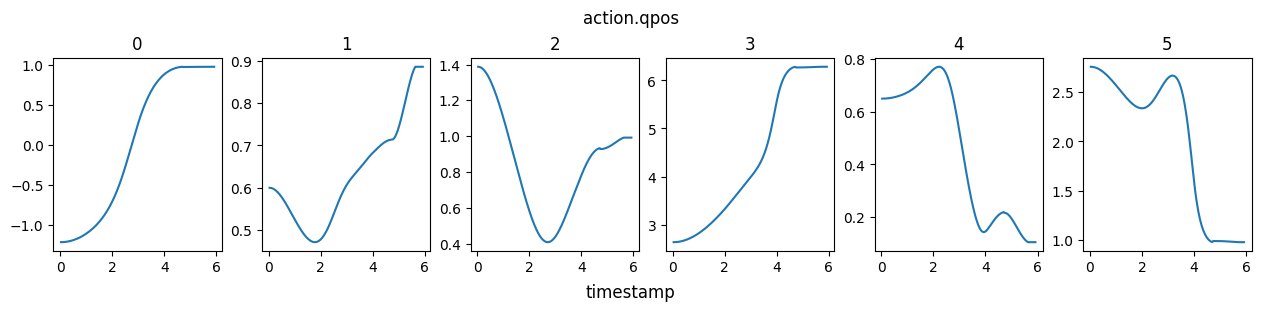

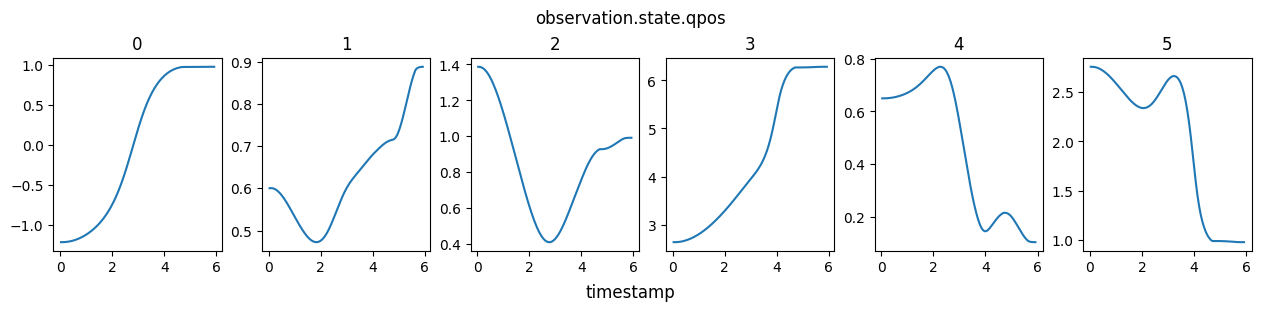

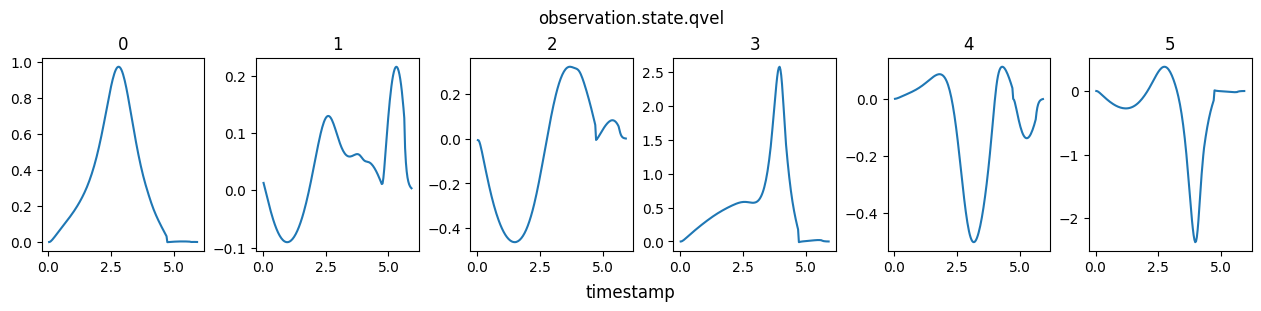

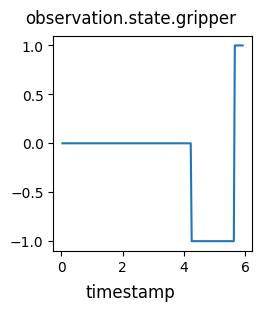

In [13]:
print(ep_dict.keys())

gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper"], sharey=False)


## Record to h5py
Don't use this - may as well go straight to a hugging face dataset
This is how the original Aloha stored the data.

In [110]:
import h5py
import os

def create_h5py_dataset(data_dict, group):
  for key, val in data_dict.items():
    if isinstance(val, dict):
      grp = group.create_group(key)
      create_h5py_dataset(data_dict[key], grp)
    elif isinstance(val, list):
      group.create_dataset(key, data=val)

def record_episodes(env, policy, dataset_dir, n=1, len=300):

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0

  while successful_trajectories < n:
    episode_idx = successful_trajectories
    print(f"Episode {episode_idx}")
    observation, info = env.reset()
    policy.reset()

    data = {"action": {"qpos": [], "gripper": []}, "observation": {"state": {"qpos": [], "gripper": []}, "pixels": []}, "reward": []}
    for step in range(len):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      # action = {"qpos": step, "gripper": 0}
      # observation = {"qpos": step, "gripper": 1}
      # reward = 2
      # print(observation)
      # print(data)
      data["action"]["qpos"].append(action["qpos"])
      data["action"]["gripper"].append(action["gripper"])
      data["observation"]["state"]["qpos"].append(observation["state"]["qpos"])
      data["observation"]["state"]["gripper"].append(observation["state"]["gripper"])
      data["observation"]["pixels"].append(observation["pixels"])
      data["reward"].append(reward)
    
    if policy.stage == 4:
      path = dataset_dir + f"/ep_{episode_idx}"
      with h5py.File(path + ".hdf5", "w") as f:
        create_h5py_dataset(data, f)
      # out = cv2.VideoWriter(path + ".mp4", cv2.VideoWriter_fourcc(*'mp4v'), env.metadata["render_fps"], (w, h))
      media.write_video(path + ".mp4", data["observation"]["pixels"], fps=env.metadata["render_fps"])
      successful_trajectories += 1
      print(f"Success, saved {path}")
    else:
      print("Failed, retrying")

    media.show_video(data["observation"]["pixels"])

    

## Record to HF dataset

In [16]:
import lerobot.common.datasets.push_dataset_to_hub.utils
from datasets import Dataset, Features, Image, Sequence, Value
from lerobot.common.datasets.push_dataset_to_hub.utils import concatenate_episodes
from lerobot.common.datasets.utils import (
    hf_transform_to_torch,
)
import os
import datetime

def record_episodes_to_hf(env, policy, dataset_dir, num_ep=1, num_frames=300):
  features = {}
  num_readings = num_ep*num_frames
  features["observation.pixels.side"] = Image()
  features["observation.pixels.gripper"] = Image()
  features["observation.state.qpos"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["observation.state.qvel"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["observation.state.gripper"] = Value(dtype="int8", id=None)
  features["reward"] = Value(dtype="int8", id=None)
  features["action.qpos"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["action.gripper"] = Value(dtype="int8", id=None)
  features["episode_index"] = Value(dtype="int64", id=None) # Which episode
  features["frame_index"] = Value(dtype="int64", id=None) # Which frame within episode
  features["timestamp"] = Value(dtype="float32", id=None)
  # features["next.done"] = Value(dtype="bool", id=None)
  features["index"] = Value(dtype="int64", id=None) # Which frame in the whole datasets

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0
  data_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "episode_index": [], "frame_index": [], "index": [],}

  while successful_trajectories < num_ep:
    ep_idx = successful_trajectories
    print(f"Episode {ep_idx}")
    observation, info = env.reset()
    policy.reset()

    ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}
    ep_dict["episode_index"] = [ep_idx] * num_frames

    for step in range(num_frames):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      ep_dict["action.qpos"].append(action["qpos"])
      ep_dict["action.gripper"].append(action["gripper"])
      ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
      ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
      ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
      ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
      ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
      ep_dict["reward"].append(reward)
      ep_dict["timestamp"].append(env.unwrapped.data.time)
      ep_dict["frame_index"].append(step)
      # data_dict["index"] = step
    
    if policy.done and terminated:
      
      # for key in ep_dict:
      #   # Setting the dtype/transforming to a tensor makes no difference as HF Datasets stores everything in Arrow format anyway
      #   dtype = getattr(torch, features[key].feature.dtype) if 'feature' in features[key].__dict__ and features[key].feature.dtype in torch.__dict__ else None
      #   ep_dict[key] = torch.tensor(ep_dict[key], dtype=dtype)
            
      media.show_video(ep_dict["observation.pixels.side"])
      for key in ep_dict:
        data_dict[key].extend(ep_dict[key])

      base_idx = successful_trajectories*num_frames
      data_dict["index"].extend(range(base_idx, base_idx + num_frames))

      successful_trajectories += 1
    else:
      print("Failed, retrying")

  print("Creating dataset")
  # data_dict = concatenate_episodes(ep_dicts)
  # print(data_dict, features)
  hf_dataset = Dataset.from_dict(data_dict, features=Features(features))
  
  hf_dataset.save_to_disk(dataset_dir + f"/scripted_trajectories_{num_ep}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.hf")

  return hf_dataset


In [17]:
policy = gym_lite6.scripted_policy.GraspPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
# record_episodes(env, policy, "dataset/pickup_side_cam", n=50)
hf_dataset = record_episodes_to_hf(env, policy, "datasets/grasp", num_ep=50, num_frames=200)
hf_dataset.set_transform(hf_transform_to_torch)


Episode 0
{0: {'start_time': 0.0, 'end_time': 3.3951640545772346, 'T_start': array([[-0.58871058, -0.43881934,  0.67886482,  0.14533527],
       [-0.42157841, -0.54988562, -0.72103914, -0.36397155],
       [ 0.68970392, -0.71067812,  0.13872673,  0.52117365],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.18448386],
       [ 0.        , -1.        ,  0.        , -0.04651871],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.18448386, -0.04651871,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Failed, retrying
Episode 0
{0: {'start_time': 0.0, 'end_time': 3.304397533500484, 'T_start': array([[ 0.83195623,  0.37416139, -0.40969755, -0.25117796],
       [ 0.20166992, -0.89182304, -0.40494556, -0.15590038],
       [-0.51689271,  0.2542733 , -0.

KeyboardInterrupt: 